845.34678 
845.34678 
845.34678 
randomly choose seed - 84638
-------------------------------------\
temperature is 37.00 degrees celsius
dt is 0.0250 ms
-------------------------------------/


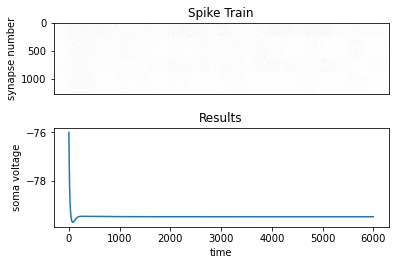

In [1]:
import os
import sys
import numpy as np
import neuron
from neuron import h
from neuron.units import ms, mV
from neuron import gui
from matplotlib import pyplot as plt
import csv
from math import exp, log
import time
import scipy
from scipy import signal

# change according to path:

# %% define NEURON model

# morphologyFilename = "morphologies/cell1.asc"
morphologyFilename = "morphologies/cell1.asc"

# biophysicalModelFilename = "L5PCbiophys5b.hoc"
biophysicalModelFilename = "L5PCbiophys3G.hoc"

# biophysicalModelTemplateFilename = "L5PCtemplate_2.hoc"
biophysicalModelTemplateFilename = "L5PCtemplate_2.hoc"

# dir_path = 'Davids/L5PC_NEURON_simulation/'
dir_path = ''


h.load_file("import3d.hoc")
h.load_file('nrngui.hoc')
h.load_file(dir_path+biophysicalModelFilename)
# h.load_file("models/L5PCbiophys3G.hoc")
h.load_file(dir_path+biophysicalModelTemplateFilename)
L5PC = h.L5PCtemplate(dir_path+morphologyFilename)
cvode = h.CVode()
useCvode = True
if useCvode:
    cvode.active(1)

h.celsius = 37
v_rest = -78

# get or randomly generate random seed
try:
    randomSeed = int(sys.argv[1])
    print('random seed selected by user - %d' % (randomSeed))
except:
    randomSeed = np.random.randint(100000)
    print('randomly choose seed - %d' % (randomSeed))

np.random.seed(randomSeed)

# NOTE: during this project I've changed my coding style
# and was too lazy to edit the old code to match the new style
# so please ignore any style related wierdness
# thanks for not being petty about unimportant shit

# ALSO NOTE: prints are for logging purposes

# %% define simulation params

# general simulation parameters
numSimulations = 1  # original: 128
totalSimDurationInSec = 6

# switch whether to store dendritic voltage traces (DVTs), which take up a lot of storage
collectAndSaveDVTs = False

# high res sampling of the voltage and nexus voltages
numSamplesPerMS_HighRes = 8

# synapse type
excitatorySynapseType = 'NMDA'  # supported options: {'AMPA','NMDA'}
# excitatorySynapseType = 'AMPA'    # supported options: {'AMPA','NMDA'}
inhibitorySynapseType = 'GABA_A'

# use active dendritic conductances switch
useActiveDendrites = True

# attenuation factor for the conductance of the SK channel
SKE2_mult_factor = 1.0
# SKE2_mult_factor = 0.1

# determine the voltage activation curve of the Ih current (HCN channel)
Ih_vshift = 0

# simulation duration
sim_duration_sec = totalSimDurationInSec
sim_duration_ms = 1000 * sim_duration_sec

# define inst rate between change interval and smoothing sigma options
inst_rate_sampling_time_interval_options_ms = [25, 30, 35, 40, 45, 55, 60, 65, 70, 75, 80, 85, 90, 100, 150, 200, 300,
                                               450]
temporal_inst_rate_smoothing_sigma_options_ms = [25, 30, 35, 40, 50, 60, 80, 100, 150, 200, 300, 400, 500, 600]

inst_rate_sampling_time_interval_jitter_range = 20
temporal_inst_rate_smoothing_sigma_jitter_range = 20

# number of spike ranges for the simulation

# AMPA with attenuated SK_E2 conductance
# num_bas_ex_spikes_per_100ms_range = [0,1900]
# num_bas_ex_inh_spike_diff_per_100ms_range = [-1500,300]
# num_apic_ex_spikes_per_100ms_range = [0,2000]
# num_apic_ex_inh_spike_diff_per_100ms_range = [-1500,300]

# AMPA
# num_bas_ex_spikes_per_100ms_range = [0,1900]
# num_bas_ex_inh_spike_diff_per_100ms_range = [-1650,150]
# num_apic_ex_spikes_per_100ms_range = [0,2000]
# num_apic_ex_inh_spike_diff_per_100ms_range = [-1650,150]

# NMDA
num_bas_ex_spikes_per_100ms_range = [0, 800]
num_bas_ex_inh_spike_diff_per_100ms_range = [-600, 200]
num_apic_ex_spikes_per_100ms_range = [0, 800]
num_apic_ex_inh_spike_diff_per_100ms_range = [-600, 200]

# "regularization" param for the segment lengths (mainly used to not divide by very small numbers)
min_seg_length_um = 10.0

# beaurrocracy
showPlots = True
resultsSavedIn_rootFolder = '/tmp/' #'/Mjolnir/University/Labs/results/'  # '/david.beniaguev/Reseach/Single_Neuron_InOut/ExperimentalData/'

totalSimDurationInMS = 1000 * totalSimDurationInSec


# %% define some helper functions


def generate_input_spike_trains_for_simulation(sim_duration_ms, basal_seg_length_um, apical_seg_length_um,
                                               min_seg_length_um,
                                               num_bas_ex_spikes_per_100ms_range, num_apic_ex_spikes_per_100ms_range,
                                               num_bas_ex_inh_spike_diff_per_100ms_range,
                                               num_apic_ex_inh_spike_diff_per_100ms_range,
                                               inst_rate_sampling_time_interval_options_ms,
                                               temporal_inst_rate_smoothing_sigma_options_ms):
    # extract the number of basal and apical segments
    num_basal_segments = len(basal_seg_length_um)
    num_apical_segments = len(apical_seg_length_um)

    # adjust segment lengths (with "min_seg_length_um")
    adjusted_basal_length_um = min_seg_length_um + basal_seg_length_um
    adjusted_apical_length_um = min_seg_length_um + apical_seg_length_um

    # calc sum of seg length (to be used for normalization later on)
    total_adjusted_basal_tree_length_um = adjusted_basal_length_um.sum()
    total_adjusted_apical_tree_length_um = adjusted_apical_length_um.sum()

    # randomly sample inst rate (with some uniform noise) smoothing sigma
    keep_inst_rate_const_for_ms = inst_rate_sampling_time_interval_options_ms[
        np.random.randint(len(inst_rate_sampling_time_interval_options_ms))]
    keep_inst_rate_const_for_ms += int(
        2 * inst_rate_sampling_time_interval_jitter_range * np.random.rand() - inst_rate_sampling_time_interval_jitter_range)

    # randomly sample smoothing sigma (with some uniform noise)
    temporal_inst_rate_smoothing_sigma = temporal_inst_rate_smoothing_sigma_options_ms[
        np.random.randint(len(temporal_inst_rate_smoothing_sigma_options_ms))]
    temporal_inst_rate_smoothing_sigma += int(
        2 * temporal_inst_rate_smoothing_sigma_jitter_range * np.random.rand() - temporal_inst_rate_smoothing_sigma_jitter_range)

    num_inst_rate_samples = int(np.ceil(float(sim_duration_ms) / keep_inst_rate_const_for_ms))

    # create the coarse inst rates with units of "total spikes per tree per 100 ms"
    num_bas_ex_spikes_per_100ms = np.random.uniform(low=num_bas_ex_spikes_per_100ms_range[0],
                                                    high=num_bas_ex_spikes_per_100ms_range[1],
                                                    size=(1, num_inst_rate_samples))
    num_bas_inh_spikes_low_range = np.maximum(0,
                                              num_bas_ex_spikes_per_100ms + num_bas_ex_inh_spike_diff_per_100ms_range[
                                                  0])
    num_bas_inh_spikes_high_range = num_bas_ex_spikes_per_100ms + num_bas_ex_inh_spike_diff_per_100ms_range[1]
    num_bas_inh_spikes_per_100ms = np.random.uniform(low=num_bas_inh_spikes_low_range,
                                                     high=num_bas_inh_spikes_high_range,
                                                     size=(1, num_inst_rate_samples))

    num_apic_ex_spikes_per_100ms = np.random.uniform(low=num_apic_ex_spikes_per_100ms_range[0],
                                                     high=num_apic_ex_spikes_per_100ms_range[1],
                                                     size=(1, num_inst_rate_samples))
    num_apic_inh_spikes_low_range = np.maximum(0, num_apic_ex_spikes_per_100ms +
                                               num_apic_ex_inh_spike_diff_per_100ms_range[0])
    num_apic_inh_spikes_high_range = num_apic_ex_spikes_per_100ms + num_apic_ex_inh_spike_diff_per_100ms_range[1]
    num_apic_inh_spikes_per_100ms = np.random.uniform(low=num_apic_inh_spikes_low_range,
                                                      high=num_apic_inh_spikes_high_range,
                                                      size=(1, num_inst_rate_samples))

    # convert to units of "per_1um_per_1ms"
    ex_bas_spike_rate_per_1um_per_1ms = num_bas_ex_spikes_per_100ms / (total_adjusted_basal_tree_length_um * 100.0)
    inh_bas_spike_rate_per_1um_per_1ms = num_bas_inh_spikes_per_100ms / (total_adjusted_basal_tree_length_um * 100.0)
    ex_apic_spike_rate_per_1um_per_1ms = num_apic_ex_spikes_per_100ms / (total_adjusted_apical_tree_length_um * 100.0)
    inh_apic_spike_rate_per_1um_per_1ms = num_apic_inh_spikes_per_100ms / (total_adjusted_apical_tree_length_um * 100.0)

    # kron by space (uniform distribution across branches per tree)
    ex_bas_spike_rate_per_seg_per_1ms = np.kron(ex_bas_spike_rate_per_1um_per_1ms, np.ones((num_basal_segments, 1)))
    inh_bas_spike_rate_per_seg_per_1ms = np.kron(inh_bas_spike_rate_per_1um_per_1ms, np.ones((num_basal_segments, 1)))
    ex_apic_spike_rate_per_seg_per_1ms = np.kron(ex_apic_spike_rate_per_1um_per_1ms, np.ones((num_apical_segments, 1)))
    inh_apic_spike_rate_per_seg_per_1ms = np.kron(inh_apic_spike_rate_per_1um_per_1ms,
                                                  np.ones((num_apical_segments, 1)))

    # vstack basal and apical
    ex_spike_rate_per_seg_per_1ms = np.vstack((ex_bas_spike_rate_per_seg_per_1ms, ex_apic_spike_rate_per_seg_per_1ms))
    inh_spike_rate_per_seg_per_1ms = np.vstack(
        (inh_bas_spike_rate_per_seg_per_1ms, inh_apic_spike_rate_per_seg_per_1ms))

    # add some spatial multiplicative randomness (that will be added to the sampling noise)
    ex_spike_rate_per_seg_per_1ms = np.random.uniform(low=0.5, high=1.5,
                                                      size=ex_spike_rate_per_seg_per_1ms.shape) * ex_spike_rate_per_seg_per_1ms
    inh_spike_rate_per_seg_per_1ms = np.random.uniform(low=0.5, high=1.5,
                                                       size=inh_spike_rate_per_seg_per_1ms.shape) * inh_spike_rate_per_seg_per_1ms

    # concatenate the adjusted length
    adjusted_length_um = np.hstack((adjusted_basal_length_um, adjusted_apical_length_um))

    # multiply each segment by it's length (now every segment will have firing rate proportional to it's length)
    ex_spike_rate_per_seg_per_1ms = ex_spike_rate_per_seg_per_1ms * np.tile(adjusted_length_um[:, np.newaxis],
                                                                            [1, ex_spike_rate_per_seg_per_1ms.shape[1]])
    inh_spike_rate_per_seg_per_1ms = inh_spike_rate_per_seg_per_1ms * np.tile(adjusted_length_um[:, np.newaxis], [1,
                                                                                                                  inh_spike_rate_per_seg_per_1ms.shape[
                                                                                                                      1]])

    # kron by time (crop if there are leftovers in the end) to fill up the time to 1ms time bins
    ex_spike_rate_per_seg_per_1ms = np.kron(ex_spike_rate_per_seg_per_1ms, np.ones((1, keep_inst_rate_const_for_ms)))[:,
                                    :sim_duration_ms]
    inh_spike_rate_per_seg_per_1ms = np.kron(inh_spike_rate_per_seg_per_1ms, np.ones((1, keep_inst_rate_const_for_ms)))[
                                     :, :sim_duration_ms]

    # filter the inst rates according to smoothing sigma
    smoothing_window = signal.gaussian(1.0 + 7 * temporal_inst_rate_smoothing_sigma,
                                       std=temporal_inst_rate_smoothing_sigma)[np.newaxis, :]
    smoothing_window /= smoothing_window.sum()
    seg_inst_rate_ex_smoothed = signal.convolve(ex_spike_rate_per_seg_per_1ms, smoothing_window, mode='same')
    seg_inst_rate_inh_smoothed = signal.convolve(inh_spike_rate_per_seg_per_1ms, smoothing_window, mode='same')

    # sample the instantanous spike prob and then sample the actual spikes
    ex_inst_spike_prob = np.random.exponential(scale=seg_inst_rate_ex_smoothed)
    ex_spikes_bin = np.random.rand(ex_inst_spike_prob.shape[0], ex_inst_spike_prob.shape[1]) < ex_inst_spike_prob

    inh_inst_spike_prob = np.random.exponential(scale=seg_inst_rate_inh_smoothed)
    inh_spikes_bin = np.random.rand(inh_inst_spike_prob.shape[0], inh_inst_spike_prob.shape[1]) < inh_inst_spike_prob

    return ex_spikes_bin, inh_spikes_bin


def GetDirNameAndFileName(numOutputSpikes, randomSeed):
    # string to describe model name based on params

    cellType = 'L5PC'
    synapseTypes = excitatorySynapseType + '_' + inhibitorySynapseType
    dendritesKind = 'activeDendrites'
    if not useActiveDendrites:
        dendritesKind = 'passiveDendrites'
    else:
        dendritesKind += '_Ih_vshift_%d_SKE2_mult_%d' % (Ih_vshift, 100 * SKE2_mult_factor)

    modelString = cellType + '__' + dendritesKind + '__' + synapseTypes
    dirToSaveIn = resultsSavedIn_rootFolder + modelString + '//'

    # string to describe input
    string1 = 'exBas_%d_%d_inhBasDiff_%d_%d' % (
    num_bas_ex_spikes_per_100ms_range[0], num_bas_ex_spikes_per_100ms_range[1],
    num_bas_ex_inh_spike_diff_per_100ms_range[0], num_bas_ex_inh_spike_diff_per_100ms_range[1])
    string2 = 'exApic_%d_%d_inhApicDiff_%d_%d' % (
    num_apic_ex_spikes_per_100ms_range[0], num_apic_ex_spikes_per_100ms_range[1],
    num_apic_ex_inh_spike_diff_per_100ms_range[0], num_apic_ex_inh_spike_diff_per_100ms_range[1])
    inputString = string1 + '__' + string2

    # string to describe simulation
    savedDVTs = ''
    if collectAndSaveDVTs:
        savedDVTs = 'DVTs'

    string3 = 'saved_InputSpikes_%s__%d_outSpikes__%d_simulationRuns__%d_secDuration__randomSeed_%d'
    simulationString = string3 % (savedDVTs, numOutputSpikes, numSimulations, totalSimDurationInSec, randomSeed)

    filenameToSave = inputString + '__' + simulationString + '.p'

    return dirToSaveIn, filenameToSave


def GetDistanceBetweenSections(sourceSection, destSection):
    h.distance(sec=sourceSection)
    return h.distance(0, sec=destSection)


# AMPA synapse
def DefineSynapse_AMPA(segment, gMax=0.0004):
    synapse = h.ProbUDFsyn2(segment)

    synapse.tau_r = 0.3
    synapse.tau_d = 3.0
    synapse.gmax = gMax
    synapse.e = 0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# NMDA synapse
def DefineSynapse_NMDA(segment, gMax=0.0004):
    synapse = h.ProbAMPANMDA2(segment)

    synapse.tau_r_AMPA = 0.3
    synapse.tau_d_AMPA = 3.0
    synapse.tau_r_NMDA = 2.0
    synapse.tau_d_NMDA = 70.0
    synapse.gmax = gMax
    synapse.e = 0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA A synapse
def DefineSynapse_GABA_A(segment, gMax=0.001):
    synapse = h.ProbUDFsyn2(segment)

    synapse.tau_r = 0.2
    synapse.tau_d = 8
    synapse.gmax = gMax
    synapse.e = -80
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA B synapse
def DefineSynapse_GABA_B(segment, gMax=0.001):
    synapse = h.ProbUDFsyn2(segment)

    synapse.tau_r = 3.5
    synapse.tau_d = 260.9
    synapse.gmax = gMax
    synapse.e = -97
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


# GABA A+B synapse
def DefineSynapse_GABA_AB(segment, gMax=0.001):
    synapse = h.ProbGABAAB_EMS(segment)

    synapse.tau_r_GABAA = 0.2
    synapse.tau_d_GABAA = 8
    synapse.tau_r_GABAB = 3.5
    synapse.tau_d_GABAB = 260.9
    synapse.gmax = gMax
    synapse.e_GABAA = -80
    synapse.e_GABAB = -97
    synapse.GABAB_ratio = 0.0
    synapse.Use = 1
    synapse.u0 = 0
    synapse.Dep = 0
    synapse.Fac = 0

    return synapse


def ConnectEmptyEventGenerator(synapse):
    netConnection = h.NetCon(None, synapse)
    netConnection.delay = 0
    netConnection.weight[0] = 1

    return netConnection


# create a single image of both excitatory and inhibitory spikes and the dendritic voltage traces
def CreateCombinedColorImage(dendriticVoltageTraces, excitatoryInputSpikes, inhibitoryInputSpikes):
    minV = -85
    maxV = 35

    excitatoryInputSpikes = signal.fftconvolve(excitatoryInputSpikes, np.ones((3, 3)), mode='same')
    inhibitoryInputSpikes = signal.fftconvolve(inhibitoryInputSpikes, np.ones((3, 3)), mode='same')

    stimulationImage = np.zeros((np.shape(excitatoryInputSpikes)[0], np.shape(excitatoryInputSpikes)[1], 3))
    stimulationImage[:, :, 0] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV) + inhibitoryInputSpikes
    stimulationImage[:, :, 1] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV) + excitatoryInputSpikes
    stimulationImage[:, :, 2] = 0.98 * (dendriticVoltageTraces - minV) / (maxV - minV)
    stimulationImage[stimulationImage > 1] = 1

    return stimulationImage


# %% collect everything we need about the model

# Get a list of all sections
listOfBasalSections = [L5PC.dend[x] for x in range(len(L5PC.dend))]
listOfApicalSections = [L5PC.apic[x] for x in range(len(L5PC.apic))]
allSections = listOfBasalSections + listOfApicalSections
allSectionsType = ['basal' for x in listOfBasalSections] + ['apical' for x in listOfApicalSections]
allSectionsLength = []
allSections_DistFromSoma = []

allSegments = []
allSegmentsLength = []
allSegmentsType = []
allSegments_DistFromSoma = []
allSegments_SectionDistFromSoma = []
allSegments_SectionInd = []
# get a list of all segments
for k, section in enumerate(allSections):
    allSectionsLength.append(section.L)
    allSections_DistFromSoma.append(GetDistanceBetweenSections(L5PC.soma[0], section))
    for currSegment in section:
        allSegments.append(currSegment)
        allSegmentsLength.append(float(section.L) / section.nseg)
        allSegmentsType.append(allSectionsType[k])
        allSegments_DistFromSoma.append(
            GetDistanceBetweenSections(L5PC.soma[0], section) + float(section.L) * currSegment.x)
        allSegments_SectionDistFromSoma.append(GetDistanceBetweenSections(L5PC.soma[0], section))
        allSegments_SectionInd.append(k)

# set Ih vshift value and SK multiplicative factor
for section in allSections:
    section.vshift_Ih = Ih_vshift
L5PC.soma[0].vshift_Ih = Ih_vshift

list_of_axonal_sections = [L5PC.axon[x] for x in range(len(L5PC.axon))]
list_of_somatic_sections = [L5PC.soma[x] for x in range(len(L5PC.soma))]
all_sections_with_SKE2 = list_of_somatic_sections + listOfApicalSections

for section in all_sections_with_SKE2:
    orig_SKE2_g = section.gSK_E2bar_SK_E2
    new_SKE2_g = orig_SKE2_g * SKE2_mult_factor
    section.gSK_E2bar_SK_E2 = new_SKE2_g
    # print('SKE2 conductance before update = %.10f' %(orig_SKE2_g))
    # print('SKE2 conductance after  update = %.10f (actual)' %(section.gSK_E2bar_SK_E2))

# Calculate total dendritic length
numBasalSegments = 0
numApicalSegments = 0
totalBasalDendriticLength = 0
totalApicalDendriticLength = 0

basal_seg_length_um = []
apical_seg_length_um = []
for k, segmentLength in enumerate(allSegmentsLength):
    if allSegmentsType[k] == 'basal':
        basal_seg_length_um.append(segmentLength)
        totalBasalDendriticLength += segmentLength
        numBasalSegments += 1
    if allSegmentsType[k] == 'apical':
        apical_seg_length_um.append(segmentLength)
        totalApicalDendriticLength += segmentLength
        numApicalSegments += 1

totalDendriticLength = sum(allSectionsLength)
totalNumSegments = len(allSegments)

# extract basal and apical segment lengths
num_basal_segments = len(basal_seg_length_um)
num_apical_segments = len(apical_seg_length_um)

basal_seg_length_um = np.array(basal_seg_length_um)
apical_seg_length_um = np.array(apical_seg_length_um)

assert (totalNumSegments == (numBasalSegments + numApicalSegments))
assert (abs(totalDendriticLength - (totalBasalDendriticLength + totalApicalDendriticLength)) < 0.00001)

totalNumOutputSpikes = 0
numOutputSpikesPerSim = []
listOfISIs = []
listOfSingleSimulationDicts = []

## run all simulations
experimentStartTime = time.time()
print('-------------------------------------\\')
print('temperature is %.2f degrees celsius' % (h.celsius))
print('dt is %.4f ms' % (h.dt))
print('-------------------------------------/')

def create_input_matrix(synapses, samples, bias):
    arr = np.random.rand(synapses, samples)
    arr = arr > bias
    return arr

def simulate_from_previous(filename):
    objects = []
    with (open(filename, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    dct = objects[0]['Results']['listOfSingleSimulationDicts'][0]
    exInput = np.array(
        [[bool(t in set(dct['exInputSpikeTimes'][synapse])) for t in range(sim_duration_ms)] for synapse in
         range(639)])
    inInput = np.array(
        [[bool(t in set(dct['inhInputSpikeTimes'][synapse])) for t in range(sim_duration_ms)] for synapse in
         range(639)])
    return exInput, inInput


ex_spikes_bin, inh_spikes_bin = generate_input_spike_trains_for_simulation(sim_duration_ms,
                                                                           basal_seg_length_um,
                                                                           apical_seg_length_um,
                                                                           min_seg_length_um,
                                                                           num_bas_ex_spikes_per_100ms_range,
                                                                           num_apic_ex_spikes_per_100ms_range,
                                                                           num_bas_ex_inh_spike_diff_per_100ms_range,
                                                                           num_apic_ex_inh_spike_diff_per_100ms_range,
                                                                           inst_rate_sampling_time_interval_options_ms,
                                                                           temporal_inst_rate_smoothing_sigma_options_ms)
full_matrix = np.concatenate([ex_spikes_bin, inh_spikes_bin])
ex_spikes_bin = create_input_matrix(639, 6000, 0.8)
inh_spikes_bin = create_input_matrix(639, 6000, 0.9)
# inputSpikeTrains_ex = np.ones((639, 6000)).astype(bool)
# inputSpikeTrains_inh = np.zeros((639, 6000)).astype(bool)

exSpikeSegInds, exSpikeTimes = np.nonzero(ex_spikes_bin)

exSpikeTimesMap = {}
for segInd, synTime in zip(exSpikeSegInds, exSpikeTimes):
    if segInd in exSpikeTimesMap.keys():
        exSpikeTimesMap[segInd].append(synTime)
    else:
        exSpikeTimesMap[segInd] = [synTime]

inhSpikeSegInds, inhSpikeTimes = np.nonzero(inh_spikes_bin)
inhSpikeTimesMap = {}
for segInd, synTime in zip(inhSpikeSegInds, inhSpikeTimes):
    if segInd in inhSpikeTimesMap.keys():
        inhSpikeTimesMap[segInd].append(synTime)
    else:
        inhSpikeTimesMap[segInd] = [synTime]

## run simulation ########################
allExNetCons = []
allExNetConEventLists = []

allInhNetCons = []
allInhNetConEventLists = []

allExSynapses = []
allInhSynapses = []

for segInd, segment in enumerate(allSegments):
    ###### excitation ######

    # define synapse and connect it to a segment
    if excitatorySynapseType == 'AMPA':
        exSynapse = DefineSynapse_AMPA(segment)
    elif excitatorySynapseType == 'NMDA':
        exSynapse = DefineSynapse_NMDA(segment)
    else:
        assert False, 'Not supported Excitatory Synapse Type'
    allExSynapses.append(exSynapse)

    # connect synapse
    netConnection = h.NetCon(None, exSynapse)
    netConnection.delay = 0
    netConnection.weight[0] = 1

    # update lists
    allExNetCons.append(netConnection)
    if segInd in exSpikeTimesMap.keys():
        allExNetConEventLists.append(exSpikeTimesMap[segInd])
    else:
        allExNetConEventLists.append([])

    ###### inhibition ######

    # define synapse and connect it to a segment
    if inhibitorySynapseType == 'GABA_A':
        inhSynapse = DefineSynapse_GABA_A(segment)
    elif inhibitorySynapseType == 'GABA_B':
        inhSynapse = DefineSynapse_GABA_B(segment)
    elif inhibitorySynapseType == 'GABA_AB':
        inhSynapse = DefineSynapse_GABA_AB(segment)
    else:
        assert False, 'Not supported Inhibitory Synapse Type'
    allInhSynapses.append(inhSynapse)

    # connect synapse
    netConnection = ConnectEmptyEventGenerator(inhSynapse)

    # update lists
    allInhNetCons.append(netConnection)
    if segInd in inhSpikeTimesMap.keys():
        allInhNetConEventLists.append(inhSpikeTimesMap[segInd])
    else:
        allInhNetConEventLists.append([])  # insert empty list if no event

# define function to be run at the begining of the simulation to add synaptic events
def AddAllSynapticEvents():
    for exNetCon, eventsList in zip(allExNetCons, allExNetConEventLists):
        for eventTime in eventsList:
            exNetCon.event(eventTime)
    for inhNetCon, eventsList in zip(allInhNetCons, allInhNetConEventLists):
        for eventTime in eventsList:
            inhNetCon.event(eventTime)

def single_soma_netcon():
    synapse = DefineSynapse_NMDA(L5PC.soma[0](.1))
    netConnection = h.NetCon(None, synapse)
    netConnection.delay = 0
    netConnection.weight[0] = 1
    netConnection.event(10)
    return synapse, netConnection

# add voltage and time recordings

# record time
recTime = h.Vector().record(h._ref_t)

# record soma voltage
recVoltageSoma = h.Vector().record(L5PC.soma[0](0.10)._ref_v)

# # record nexus voltage
# nexusSectionInd = 50
# if toPlot: recVoltageNexus = h.Vector().record(L5PC.apic[nexusSectionInd](0.9)._ref_v)

# record segments
# if toPlot:
#     recVoltage_allSegments = []
#     for segInd, segment in enumerate(allSegments):
#         voltageRecSegment = h.Vector()
#         voltageRecSegment.record(segment._ref_v)
#         recVoltage_allSegments.append(voltageRecSegment)


# make sure the following line will be run after h.finitialize()
fih = h.FInitializeHandler('nrnpython("AddAllSynapticEvents()")')
h.finitialize(-76)
h.continuerun(sim_duration_ms)

origRecordingTime = np.array(recTime.to_python())
origSomaVoltage = np.array(recVoltageSoma.to_python())

plt.figure()
plt.subplot(2,1,1)
plt.title("Spike Train")
plt.imshow(full_matrix, cmap='binary')
plt.xticks([])
plt.ylabel("synapse number")
plt.subplot(2,1,2)
plt.title("Results")
plt.plot(recTime, origSomaVoltage)
plt.xlabel("time")
plt.ylabel("soma voltage")
plt.show()